## 1.Autoencoder

In [3]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Sequential
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
from keras.models import Model
from keras import backend as K 
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras
from keras import layers

In [4]:
# load data 
data, info = tfds.load('cifar10', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteF5J3NO/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteF5J3NO/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [9]:
preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])

ds_train = data['train'].map(preprocess).map(lambda x, y: (x, x)).cache().batch(32).repeat().prefetch(5)
ds_test = data["test"].map(preprocess)

In [10]:
img_shape = info.features['image'].shape
print(img_shape)

(32, 32, 3)


In [20]:
encoder = tfk.Sequential([
  tfkl.Conv2D(filters=32, kernel_size=(3,3),padding="same", activation='relu', input_shape=img_shape),
  tfkl.MaxPooling2D((2,2),padding="same"),
  tfkl.Conv2D(filters = 32, kernel_size=(3,3),activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D((2,2),padding="same"),
  tfkl.Conv2D(filters = 16,kernel_size=(3,3),activation=tf.nn.relu,padding='same'),
  tfkl.MaxPool2D((2,2),padding="same"),
  tfkl.Conv2D(filters = 4,kernel_size=(1,1),padding='same',activation=tf.nn.sigmoid)
])
encoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 4)          

In [21]:
decoder = tfk.Sequential([
    tfkl.InputLayer((4, 4, 4)),
    tfkl.Conv2D(filters = 16,kernel_size=(3,3),activation=tf.nn.relu,padding='same'),
    tfkl.UpSampling2D((2,2)),
    tfkl.Conv2D(filters = 32, kernel_size=(3,3),activation=tf.nn.relu,padding="same"),
    tfkl.UpSampling2D((2,2)),
    tfkl.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,padding="same"),
    tfkl.UpSampling2D((2,2)),

    tfkl.Conv2D(filters = 3, kernel_size=(3,3), padding="same", activation='sigmoid')
    ])

decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 4, 4, 16)          592       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 3)        

In [33]:
x = tfkl.Input(img_shape)

h = encoder(x)
xhat = decoder(h)

autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics = tfk.metrics.Accuracy()
)

results = autoencoder.fit(ds_train, steps_per_epoch=100, epochs=20)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 4)           14836     
_________________________________________________________________
sequential_6 (Sequential)    (None, 32, 32, 3)         15347     
Total params: 30,183
Trainable params: 30,183
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
100/100 [==============================] - 14s 137ms/step - loss: 0.5912 - accuracy: 1.0173e-07
Epoch 2/20
100/100 [==============================] - 14s 137ms/step - loss: 0.5837 - accuracy: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 14s 137ms/step - loss: 0.5829 - accuracy: 1.0173e-07
Epoch 4/20
100/100 [==============================] - 14s 

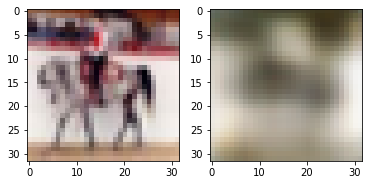

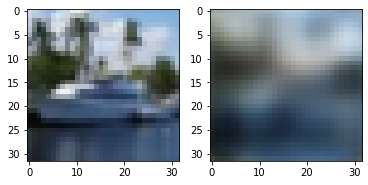

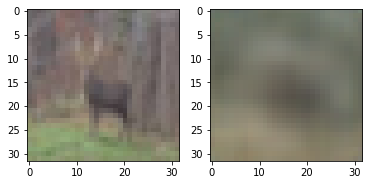

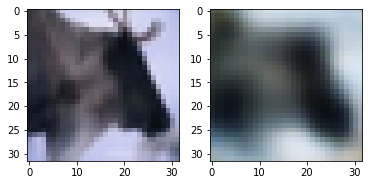

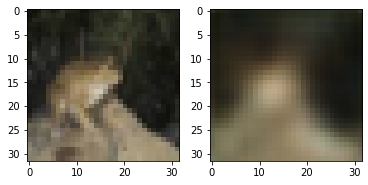

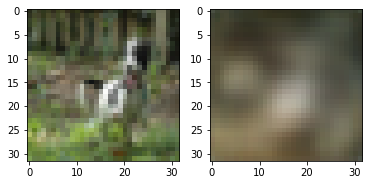

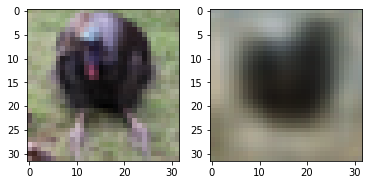

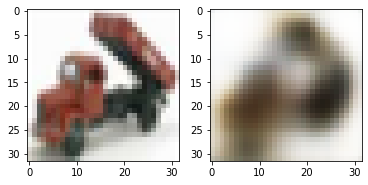

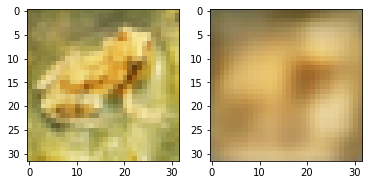

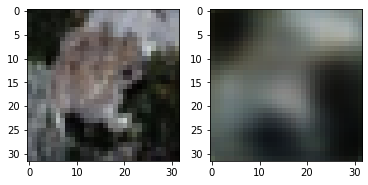

In [34]:
imgs = next(iter(ds_train))[0]
for i in range(10):
  plt.subplot(1, 2, 1)
  plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
  plt.subplot(1, 2, 2, )
  plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
  plt.show()

## 2.Image Classification

### 2.1 Deep CNN

In [5]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255., 
                        tf.one_hot(d["label"], depth=10))

In [6]:
ds_train = data['train'].map(preprocess).cache().batch(8)
ds_test = data["test"].map(preprocess).cache().batch(8)

In [13]:
model_cnn = tfk.Sequential()

model_cnn.add(tfkl.Conv2D(filters = 128, kernel_size=(3,3), strides=1, padding="same", activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(tfkl.MaxPool2D(pool_size = (2,2)))
model_cnn.add(tfkl.Dropout(.2))

model_cnn.add(tfkl.Conv2D(filters = 64, kernel_size=(3,3), strides=1, 
                      padding="same", activation='relu'))
model_cnn.add(tfkl.MaxPool2D(pool_size = (2,2)))
model_cnn.add(tfkl.Dropout(.2))

model_cnn.add(tfkl.Conv2D(filters = 32, kernel_size=(3,3), strides=1, 
                      padding="same", activation='relu'))
model_cnn.add(tfkl.MaxPool2D(pool_size = (2,2)))
model_cnn.add(tfkl.Dropout(.2))

model_cnn.add(tfkl.Dense(128, activation='sigmoid'))
model_cnn.add(tfkl.Dropout(.1)) 
model_cnn.add(tfkl.Flatten())
model_cnn.add(tfkl.Dense(10, activation='softmax'))

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 32)         

In [14]:
model_cnn.compile(optimizer=tfk.optimizers.RMSprop(),
                  loss=tfk.losses.CategoricalCrossentropy(),
)

model_cnn_results = model_cnn.fit(ds_train, steps_per_epoch=100, epochs=20, validation_data = ds_test)

Epoch 1/20
100/100 [==============================] - 21s 208ms/step - loss: 2.5454 - val_loss: 2.4009
Epoch 2/20
100/100 [==============================] - 18s 185ms/step - loss: 2.3681 - val_loss: 2.2535
Epoch 3/20
100/100 [==============================] - 19s 194ms/step - loss: 2.2601 - val_loss: 2.1890
Epoch 4/20
100/100 [==============================] - 18s 182ms/step - loss: 2.1638 - val_loss: 2.1391
Epoch 5/20
100/100 [==============================] - 18s 182ms/step - loss: 2.1539 - val_loss: 2.0528
Epoch 6/20
100/100 [==============================] - 19s 190ms/step - loss: 2.1443 - val_loss: 2.1035
Epoch 7/20
100/100 [==============================] - 20s 197ms/step - loss: 2.0773 - val_loss: 2.1310
Epoch 8/20
100/100 [==============================] - 20s 202ms/step - loss: 2.0349 - val_loss: 2.0098
Epoch 9/20
100/100 [==============================] - 19s 194ms/step - loss: 2.0184 - val_loss: 2.0171
Epoch 10/20
100/100 [==============================] - 19s 194ms/step - l

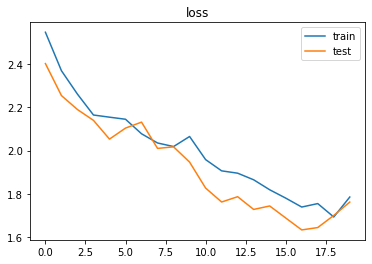

In [16]:
plt.plot(model_cnn_results.history['loss'])
plt.plot(model_cnn_results.history['val_loss'])
plt.title('loss')
plt.legend(['train','test'])

For deep CNN model, the size merges from 128 to 64 to 32. It contains 12 layers.(convolution layer + pooling layer + dropout layer) repeats 3 times.
The padding method is same.
The kernel size is 3 and stride size is 1.



### 2.2 Transfer Learning

In [17]:
from tensorflow.keras.applications import VGG16

In [19]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3)) 
model_vgg = tfk.Sequential()
model_vgg.add(conv_base)


model_vgg.add(tfkl.Flatten())
model_vgg.add(tfkl.Dense(64, activation="relu"))
model_vgg.add(tfkl.Dense(10, activation="softmax"))

model_vgg.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 14,748,170
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_vgg.compile(optimizer=tfk.optimizers.RMSprop(),loss=tfk.losses.CategoricalCrossentropy(), metrics=['accuracy'])

model_vgg_results = model_vgg.fit(ds_train, steps_per_epoch=20, epochs=10, validation_data = ds_test)

Epoch 1/10
20/20 [==============================] - 132s 7s/step - loss: 5.7338 - accuracy: 0.0750 - val_loss: 2.3428 - val_accuracy: 0.1000
Epoch 2/10
20/20 [==============================] - 133s 7s/step - loss: 2.2982 - accuracy: 0.1250 - val_loss: 2.3444 - val_accuracy: 0.1000
Epoch 3/10
20/20 [==============================] - 132s 7s/step - loss: 2.7796 - accuracy: 0.1187 - val_loss: 2.3768 - val_accuracy: 0.1000
Epoch 4/10
20/20 [==============================] - 132s 7s/step - loss: 2.3922 - accuracy: 0.1063 - val_loss: 2.3289 - val_accuracy: 0.1000
Epoch 5/10
20/20 [==============================] - 132s 7s/step - loss: 2.5609 - accuracy: 0.1312 - val_loss: 2.3007 - val_accuracy: 0.1020
Epoch 6/10
20/20 [==============================] - 132s 7s/step - loss: 2.3140 - accuracy: 0.1125 - val_loss: 2.2867 - val_accuracy: 0.0953
Epoch 7/10
20/20 [==============================] - 132s 7s/step - loss: 2.3015 - accuracy: 0.1250 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 8/10
20

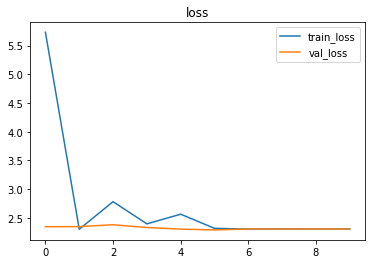

In [22]:
plt.plot(model_vgg_results.history['loss'])
plt.plot(model_vgg_results.history['val_loss'])
plt.title('loss')
plt.legend(['train_loss','val_loss'])

## 3.Text Classification

In [23]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [25]:
df = pd.read_csv("/content/drive/My Drive/Neural-Nets-and-Deep-Learning/HW3/SPAM_detection.csv")
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [27]:
df['Message'] = df['Message'].str.lower()

In [28]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [64]:
X = [preprocess_text(sen) for sen in list(df["Message"])]
y = df['category_val'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [65]:
# tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

max_features = 10000
max_len = 200
X_train = sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = sequence.pad_sequences(X_test, padding='post', maxlen=max_len)

In [60]:
print(X_train.shape)
print(X_test.shape)

(3900, 500)
(1672, 500)


### 3.1 RNN

In [68]:
model_RNN =Sequential()
model_RNN.add(tfkl.Embedding(max_features,  32, input_shape=(200, )))
model_RNN.add(tfkl.LSTM(128,return_sequences=True))
model_RNN.add(tfkl.GlobalMaxPool1D())
model_RNN.add(tfkl.Dropout(0.25))

model_RNN.add(tfkl.Dense(32,activation="relu"))
model_RNN.add(tfkl.Dropout(0.25))

model_RNN.add(tfkl.Dense(1,activation="sigmoid"))
model_RNN.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 128)          82432     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [69]:
model_RNN.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.001),metrics=['accuracy'])
model_RNN_results = model_RNN.fit(X_train,y_train, epochs=5,batch_size=64, validation_data=(X_test,y_test))

Epoch 1/5
61/61 [==============================] - 25s 411ms/step - loss: 0.4102 - accuracy: 0.8664 - val_loss: 0.3485 - val_accuracy: 0.8648
Epoch 2/5
61/61 [==============================] - 25s 405ms/step - loss: 0.2853 - accuracy: 0.9046 - val_loss: 0.3245 - val_accuracy: 0.8929
Epoch 3/5
61/61 [==============================] - 25s 408ms/step - loss: 0.1528 - accuracy: 0.9610 - val_loss: 0.2444 - val_accuracy: 0.8768
Epoch 4/5
61/61 [==============================] - 25s 411ms/step - loss: 0.1442 - accuracy: 0.9497 - val_loss: 0.0957 - val_accuracy: 0.9671
Epoch 5/5
61/61 [==============================] - 25s 405ms/step - loss: 0.0683 - accuracy: 0.9846 - val_loss: 0.0703 - val_accuracy: 0.9785


In [70]:
RNN_pred = model_RNN.predict(X_test).ravel()

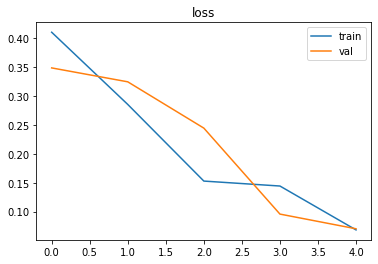

In [71]:
plt.plot(model_RNN_results.history["loss"])
plt.plot(model_RNN_results.history["val_loss"])
plt.title('loss')
plt.legend(labels=["train", "val"])

### 3.2 CNN

In [75]:
X = [preprocess_text(sen) for sen in list(df["Message"])]
y = df['category_val'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [76]:
# tokenizer
tokenizer = Tokenizer(filters=None, char_level=True)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

max_features = 10000
max_len = 100
X_train = sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = sequence.pad_sequences(X_test, padding='post', maxlen=max_len)

In [77]:
textmodel_cnn = Sequential()
textmodel_cnn.add(tfkl.Embedding(vocab_size, 100, input_length=max_len))
textmodel_cnn.add(tfkl.Conv1D(128, 5, activation='relu'))
textmodel_cnn.add(tfkl.GlobalMaxPooling1D())
textmodel_cnn.add(tfkl.Dense(10, activation='relu'))
textmodel_cnn.add(tfkl.Dense(1, activation='sigmoid'))

textmodel_cnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          2800      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 11        
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [78]:
textmodel_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [79]:
textmodel_cnn_results = textmodel_cnn.fit(X_train, y_train,
                        epochs=10,
                        verbose=False,
                        validation_data=(X_test, y_test),
                        batch_size=10)

In [80]:
CNN_pred = textmodel_cnn.predict(X_test).ravel()

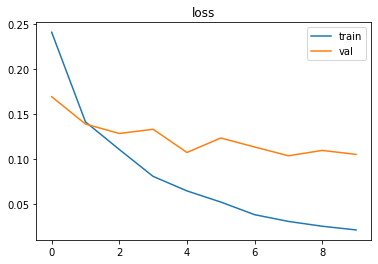

In [81]:
plt.plot(textmodel_cnn_results.history["loss"])
plt.plot(textmodel_cnn_results.history["val_loss"])
plt.title('loss')
plt.legend(labels=["train", "val"])

### 3.3

In [54]:
from sklearn.metrics import roc_curve, auc

In [82]:
fpr_rnn, tpr_rnn, rnn_ = roc_curve(y_test, RNN_pred)
auc_rnn = auc(fpr_rnn, tpr_rnn)

In [83]:
fpr_cnn, tpr_cnn, cnn_ = roc_curve(y_test, CNN_pred)
auc_cnn = auc(fpr_cnn, tpr_cnn)

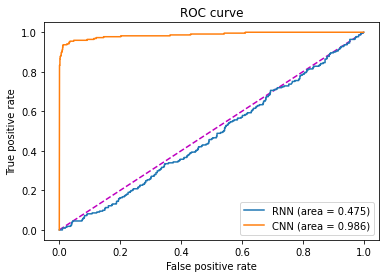

In [84]:
plt.figure()
plt.plot([0, 1], [0, 1], 'm--')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'lower right')
plt.show()